In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LSTM, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
import time
import datetime
from pandas.tseries.offsets import DateOffset
#from sktime.utils.plotting import plot_series

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
df_forFCST = pd.read_csv(  r'/content/gdrive/MyDrive/DataStore/salesD_smoothed.csv' )
#df_forFCST = pd.read_csv(  r'/content/gdrive/MyDrive/DataStore/Копия salesD_smoothed (1) - salesD_smoothed (1).csv (1).csv')
# Create a BytesIO object from the uploaded file
#file_content = io.BytesIO(uploaded['salesD_smoothed (1).csv'])


df_forFCST.set_index( 'ds', inplace = True )
df_forFCST.index = pd.to_datetime( df_forFCST.index )
df_forFCST.index
print(df_forFCST['y_mix'])


ds
2019-01-01    135.893037
2019-01-02     45.361847
2019-01-03     74.523035
2019-01-04    108.004398
2019-01-05     71.282903
                 ...    
2024-07-27    100.898801
2024-07-28     83.893385
2024-07-29    362.231558
2024-07-30    411.531065
2024-07-31    409.263676
Name: y_mix, Length: 2039, dtype: float64


In [ ]:
def windowed_dataset( series, window_size, batch_size ):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1, 0])) # Extract 'y_mix' as the label

    # Create batches of windows
    # dataset = dataset.batch( batch_size ).prefetch(1)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

    return dataset

# Visualizes time series data
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(8, 4))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Feature engineering after split
def add_time_features( df, max_mix ):
  df = df.copy()
  # max_mix = df.y_mix.max()
  df['y_mix'] = df.y_mix / max_mix
  df['month_number'] = df.index.month / df.index.month.max()
  df['day_of_week'] = df.index.dayofweek / df.index.dayofweek.max()
  df['day_of_month'] = df.index.day / df.index.day.max()
  return df

In [ ]:
def get_model(input_shape, wd = 1e-3):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape = input_shape, kernel_initializer=HeNormal()),
        MaxPooling1D(pool_size=2),

        Flatten(),

        Dense(256, activation='relu', kernel_regularizer=l2(wd)),
        Dense(128, activation='relu', kernel_regularizer=l2(wd)),
        Dense(128, activation='relu', kernel_regularizer=l2(wd)),
        Dense(64, activation='relu', kernel_regularizer=l2(wd)),
        Dense(1)
    ])
    return model
#wd 1e-4


In [ ]:
def get_compile(model, lrate = 1e-3):
    optimizer = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=lrate)

    model.compile(optimizer=optimizer,
              #loss='huber',
                loss = 'mae',
                  metrics = ['mae', 'mse'])

def get_checkpoint_every_epoch():
    return ModelCheckpoint(
        filepath='/content/gdrive/MyDrive/var/FTryModel/checkpoints_every_epoch/checkpoint_{epoch:03d}.weights.h5',
        save_weights_only=True,
        save_freq='epoch',
    )

def get_checkpoint_best_only():
    return ModelCheckpoint(
        filepath='/content/gdrive/MyDrive/var/FTryModel/checkpoints_best_only/checkpoint.weights.h5',
        save_weights_only=True,
        monitor='loss',
        save_best_only=True,
        mode='min',
    )

def get_early_stopping():
    return EarlyStopping(monitor='loss', patience=100, mode='min', min_delta=0.005)

def get_lr_schedule():
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-9 * 10**(epoch / 15))
    return lr_schedule



In [ ]:
# Split data first
split_dateSm = pd.to_datetime( '2024-07-31' )
train_dfSm = df_forFCST[ df_forFCST.index <= split_dateSm ]
# valid_dfSm = df_forFCST[ df_forFCST.index > split_dateSm ]


max_mix = df_forFCST[ df_forFCST.index <= split_dateSm ]['y_mix'].max()
train_dfSm = add_time_features( train_dfSm, max_mix )
# valid_dfSm = add_time_features( valid_dfSm, max_mix )

# Form numpy arrays
time_trainSm = np.array( train_dfSm.reset_index()['ds'] )
x_trainSm = np.array( train_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month']] )

# time_validSm = np.array( valid_dfSm.reset_index()['ds'])
# x_validSm = np.array( valid_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month']] )
print(len(x_trainSm))

2039


In [ ]:
checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
lr_shed = get_lr_schedule()
callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
callbacks = [lr_shed]

In [ ]:
batchs = 64
window_size = 360
input_shape = (window_size, x_trainSm.shape[1])
tf.keras.backend.clear_session()

model = get_model(input_shape)
get_compile(model)
#model.summary()

#validation_data = (X_val, y_val)

dataset = windowed_dataset(x_trainSm, window_size, batchs)


In [ ]:
# Train the model
history = model.fit(dataset, epochs = 50, verbose = 2, shuffle = False)

#history = model.fit(x_trainSm, y_trainSm, epochs = 100, verbose = 1, batch_size = batchs)

In [ ]:
# TEST PREDICTION

# Split data first
split_dateSm = pd.to_datetime( '2024-04-30' )
upper_boundary = pd.to_datetime( '2024-07-31' )
train_dfSm = df_forFCST[ df_forFCST.index <= split_dateSm ]
valid_dfSm = df_forFCST[ ( df_forFCST.index > split_dateSm ) & ( df_forFCST.index <= upper_boundary ) ]

# max_mix = df_forFCST[ df_forFCST.index <= split_dateSm ]['y_mix'].max()
max_mix = 679.8297498652444
train_dfSm = add_time_features( train_dfSm, max_mix )
valid_dfSm = add_time_features( valid_dfSm, max_mix )

# Form numpy arrays
time_trainSm = np.array( train_dfSm.reset_index()['ds'] )
x_trainSm = np.array( train_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month']] )

time_validSm = np.array( valid_dfSm.reset_index()['ds'])
x_validSm = np.array( valid_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month']] )

In [ ]:
# Reduce the original series
forecast_series = x_trainSm[-window_size:]


forecast_period = ( pd.to_datetime( time_validSm[-1] ) - pd.to_datetime( time_validSm[0] ) ).days + 1
final_result = np.empty( shape = (1, 1) )

for period in range( forecast_period ):

    forecast = model.predict( forecast_series[np.newaxis], verbose=0 )
    results = forecast.squeeze()

    forecast_date = time_validSm[0] + pd.Timedelta(days=period)
    month_num = forecast_date.month / 12
    day_of_week = forecast_date.dayofweek / 6
    day_of_month = forecast_date.day / 31

    # Append the new prediction and features
    forecast_series = np.append( forecast_series,
                                  [[ results, month_num, day_of_week, day_of_month ]], axis=0)
    final_result = np.append( final_result, results )

    # Remove the oldest data point
    forecast_series = forecast_series[1:]


final_result = final_result[ 1 : ] # extract only the predicted sales for plotting and grouping
#print(x_validSm[ : forecast_period, 0 ] * max_mix, final_result * max_mix)
#print(x_validSm[ : forecast_period, 0 ] * max_mix, final_result * max_mix)

# Plot the results
plot_series( time_validSm[ : forecast_period ], \
            ( x_validSm[ : forecast_period, 0 ] * max_mix, final_result * max_mix ), legend = ['x_valid', 'prediction']  )

# group by months and estimate errors
data = np.array( [ x_validSm[  : forecast_period, 0 ] * max_mix, final_result * max_mix ] ).T

df_result = pd.DataFrame( data = data, index = time_validSm[ : forecast_period ],
                          columns = [ "x_valid", "prediction"] )

df_resultGR = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
p_error = np.abs( np.array( df_resultGR["x_valid"] ) - ( np.array( df_resultGR['prediction'] ) ) ) \
    / np.array( df_resultGR["x_valid"] )

df_resultGR = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
df_resultGR['a_error'] = np.abs( np.round( \
    np.array( df_resultGR["x_valid"] ) \
    - np.array( df_resultGR['prediction'] ), 0 ) )
df_resultGR['p_error'] = np.round( ( np.array( df_resultGR["x_valid"] ) \
    -  np.array( df_resultGR['prediction'] ) ) \
    / np.array( df_resultGR["x_valid"] ), 2 )

df_resultGR


<Axes: >

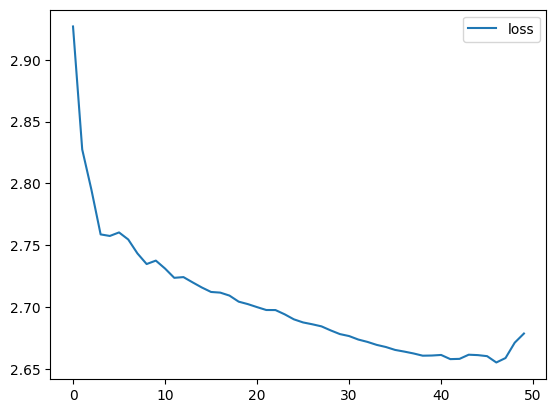

In [ ]:
df = pd.DataFrame(history.history)
#df = df[15:]
df.plot(y=['loss'])


In [ ]:
batchsi = [64]
lratesi = [5e-4, 1e-3, 1e-3, 1e-3, 3e-3]
weedi = [3e-3, 7e-4, 1e-3, 3e-3, 3e-3]
bests = []

**доп**

In [ ]:
for i in range(len(lratesi)):
            weed = weedi[i]
            lrate = lratesi[i]

            try:
                model = get_model(input_shape, weed)
                get_compile(model, lrate)
                history = model.fit(dataset, epochs = 25, verbose = 0, shuffle = False)

                # TEST PREDICTION

                # Split data first
                split_dateSm = pd.to_datetime( '2024-04-30' )
                upper_boundary = pd.to_datetime( '2024-07-31' )
                train_dfSm = df_forFCST[ df_forFCST.index <= split_dateSm ]
                valid_dfSm = df_forFCST[ ( df_forFCST.index > split_dateSm ) & ( df_forFCST.index <= upper_boundary ) ]

                # max_mix = df_forFCST[ df_forFCST.index <= split_dateSm ]['y_mix'].max()
                max_mix = 679.8297498652444
                train_dfSm = add_time_features( train_dfSm, max_mix )
                valid_dfSm = add_time_features( valid_dfSm, max_mix )

                # Form numpy arrays
                time_trainSm = np.array( train_dfSm.reset_index()['ds'] )
                x_trainSm = np.array( train_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month']] )

                time_validSm = np.array( valid_dfSm.reset_index()['ds'])
                x_validSm = np.array( valid_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month']] )


                # Reduce the original series
                forecast_series = x_trainSm[-window_size:]


                forecast_period = ( pd.to_datetime( time_validSm[-1] ) - pd.to_datetime( time_validSm[0] ) ).days + 1
                final_result = np.empty( shape = (1, 1) )

                for period in range( forecast_period ):

                    forecast = model.predict( forecast_series[np.newaxis], verbose=0 )
                    results = forecast.squeeze()

                    forecast_date = time_validSm[0] + pd.Timedelta(days=period)
                    month_num = forecast_date.month / 12
                    day_of_week = forecast_date.dayofweek / 6
                    day_of_month = forecast_date.day / 31

                    # Append the new prediction and features
                    forecast_series = np.append( forecast_series,
                                                [[ results, month_num, day_of_week, day_of_month ]], axis=0)
                    final_result = np.append( final_result, results )

                    # Remove the oldest data point
                    forecast_series = forecast_series[1:]


                final_result = final_result[ 1 : ] # extract only the predicted sales for plotting and grouping
                #print(x_validSm[ : forecast_period, 0 ] * max_mix, final_result * max_mix)
                #print(x_validSm[ : forecast_period, 0 ] * max_mix, final_result * max_mix)

                # Plot the results
                #plot_series( time_validSm[ : forecast_period ], \
                #            ( x_validSm[ : forecast_period, 0 ] * max_mix, final_result * max_mix ), legend = ['x_valid', 'prediction']  )

                # group by months and estimate errors
                data = np.array( [ x_validSm[  : forecast_period, 0 ] * max_mix, final_result * max_mix ] ).T

                df_result = pd.DataFrame( data = data, index = time_validSm[ : forecast_period ],
                                        columns = [ "x_valid", "prediction"] )

                df_resultGR = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
                p_error = np.abs( np.array( df_resultGR["x_valid"] ) - ( np.array( df_resultGR['prediction'] ) ) ) \
                    / np.array( df_resultGR["x_valid"] )

                df_resultGR = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
                df_resultGR['a_error'] = np.abs( np.round( \
                    np.array( df_resultGR["x_valid"] ) \
                    - np.array( df_resultGR['prediction'] ), 0 ) )
                df_resultGR['p_error'] = np.round( ( np.array( df_resultGR["x_valid"] ) \
                    -  np.array( df_resultGR['prediction'] ) ) \
                    / np.array( df_resultGR["x_valid"] ), 2 )
                print(batchs, lrate, weed, ': ', df_resultGR['p_error'].values)
                print(df_resultGR['x_valid'].values, df_resultGR['prediction'].values)
            except:
                print('')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


64 0.0005 0.003 :  [ 0.06  0.08 -0.04]
[9284. 9035. 9152.] [8734.01531671 8281.75383239 9558.88173801]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


64 0.001 0.0007 :  [ 0.05  0.06 -0.04]
[9284. 9035. 9152.] [8839.47202722 8466.17351237 9539.04166851]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


64 0.001 0.001 :  [ 0.08  0.1  -0.03]
[9284. 9035. 9152.] [8535.07994701 8165.72768222 9390.93640172]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


64 0.001 0.003 :  [ 0.04  0.08 -0.06]
[9284. 9035. 9152.] [8893.58241738 8328.46885445 9671.44348357]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


64 0.003 0.003 :  [ 0.08  0.1  -0.01]
[9284. 9035. 9152.] [8516.4287741  8094.98898878 9285.25899353]


In [ ]:
print(*bests, sep = '\n')
#batch_size lerning_rate (weight_decay)
#64 0.0005 0.003 :  [-0.05  0.05  0.04] in 1 7 7 *
#64 0.001 0.0007 :  [-0.02  0.06  0.05] in 1 7 8 *
#64 0.001 0.001 :  [-0.01  0.04  0.04]  in 1 6 7 **
#64 0.001 0.003 :  [-0.01  0.08  0.08]  in 1 7 9 *
#64 0.003 0.003 :                       in 1 7 8 *

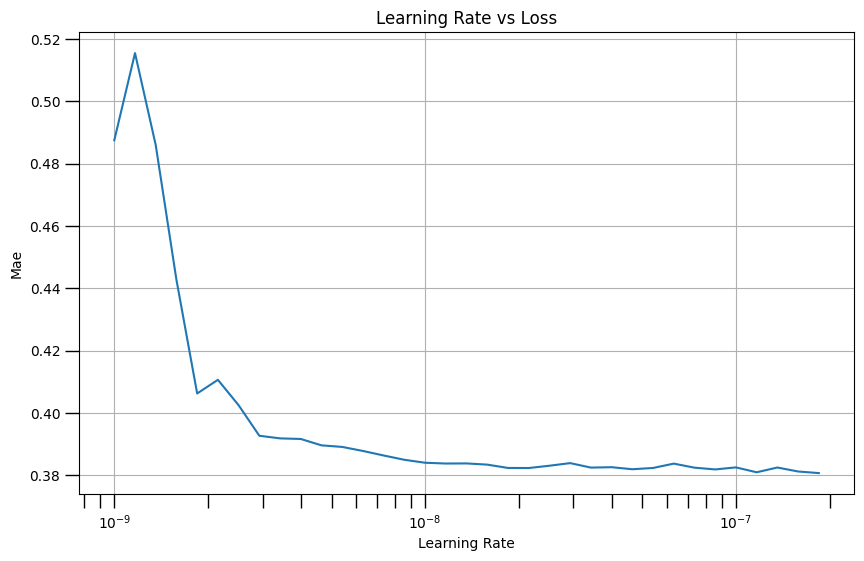

In [ ]:
# Define the learning rate array (adjust to match the number of epochs)
lrs = 1e-9 * (10 ** (np.arange(len(history.history['mae'])) / 15))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.xlabel("Learning Rate")
plt.ylabel("Mae")
plt.title("Learning Rate vs Loss")
plt.show()